Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import preprocessing, decomposition
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [2]:
# Read and import data
housing = pd.read_csv('Melbourne_housing_FULL.csv')
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [3]:
#Check the columns in the raw data
housing.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [4]:
#Check the kind of variables in the raw data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29217 entries, 0 to 29216
Data columns (total 21 columns):
Suburb           29217 non-null object
Address          29217 non-null object
Rooms            29217 non-null int64
Type             29217 non-null object
Price            22850 non-null float64
Method           29217 non-null object
SellerG          29217 non-null object
Date             29217 non-null object
Distance         29217 non-null float64
Postcode         29217 non-null int64
Bedroom2         22665 non-null float64
Bathroom         22659 non-null float64
Car              22357 non-null float64
Landsize         19649 non-null float64
BuildingArea     11817 non-null float64
YearBuilt        13473 non-null float64
CouncilArea      29215 non-null object
Lattitude        22878 non-null float64
Longtitude       22878 non-null float64
Regionname       29215 non-null object
Propertycount    29215 non-null float64
dtypes: float64(11), int64(2), object(8)
memory usage: 4.7+ MB


In [5]:
print(housing.isnull().sum())
print(len(housing))

Suburb               0
Address              0
Rooms                0
Type                 0
Price             6367
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bedroom2          6552
Bathroom          6558
Car               6860
Landsize          9568
BuildingArea     17400
YearBuilt        15744
CouncilArea          2
Lattitude         6339
Longtitude        6339
Regionname           2
Propertycount        2
dtype: int64
29217


In [6]:
#Eliminate the rows that have no info regarding price
housing1 = housing[np.isfinite(housing['Price'])] 

#Transform the data into datetime
housing1['Date'] = pd.to_datetime(housing['Date'])

#Transform the date into months and year
housing1['Month'] = housing1['Date'].dt.month
housing1['Year'] = housing1['Date'].dt.year

#Delete the property count
del housing1['Propertycount']

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/borjaregueral/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/borjaregueral/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [7]:
#Understand the time span of the data
housing1.Date.min(), housing1.Date.max()

(Timestamp('2016-01-28 00:00:00'), Timestamp('2017-12-08 00:00:00'))

In [8]:
#Consider only the sales that have taken place within the last year of data (12 months)
#mask = (housing1['Date'] > '2016-12-08')
#housing2 = housing1.loc[mask]

In [9]:
#Check the Nan values that are still remaining
print(housing1.isnull().sum())
print(len(housing1))

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2         5113
Bathroom         5117
Car              5347
Landsize         7495
BuildingArea    13685
YearBuilt       12376
CouncilArea         2
Lattitude        4949
Longtitude       4949
Regionname          2
Month               0
Year                0
dtype: int64
22850


In [10]:
#Drop the Nan values that are in the Regionname and CouncilArea columns and 
#Fill the missing values with the median of each column
housing3 = housing1.dropna(subset=[['Regionname','CouncilArea']])
housing4 = housing3.fillna(housing1.median())

In [11]:
#Check that there is no Nan value
print(housing4.isnull().sum())
print(len(housing4))

Suburb          0
Address         0
Rooms           0
Type            0
Price           0
Method          0
SellerG         0
Date            0
Distance        0
Postcode        0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
CouncilArea     0
Lattitude       0
Longtitude      0
Regionname      0
Month           0
Year            0
dtype: int64
22848


In [12]:
#Check the type of info regarding each variable
housing4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22848 entries, 1 to 29216
Data columns (total 22 columns):
Suburb          22848 non-null object
Address         22848 non-null object
Rooms           22848 non-null int64
Type            22848 non-null object
Price           22848 non-null float64
Method          22848 non-null object
SellerG         22848 non-null object
Date            22848 non-null datetime64[ns]
Distance        22848 non-null float64
Postcode        22848 non-null int64
Bedroom2        22848 non-null float64
Bathroom        22848 non-null float64
Car             22848 non-null float64
Landsize        22848 non-null float64
BuildingArea    22848 non-null float64
YearBuilt       22848 non-null float64
CouncilArea     22848 non-null object
Lattitude       22848 non-null float64
Longtitude      22848 non-null float64
Regionname      22848 non-null object
Month           22848 non-null int64
Year            22848 non-null int64
dtypes: datetime64[ns](1), float64(10), i

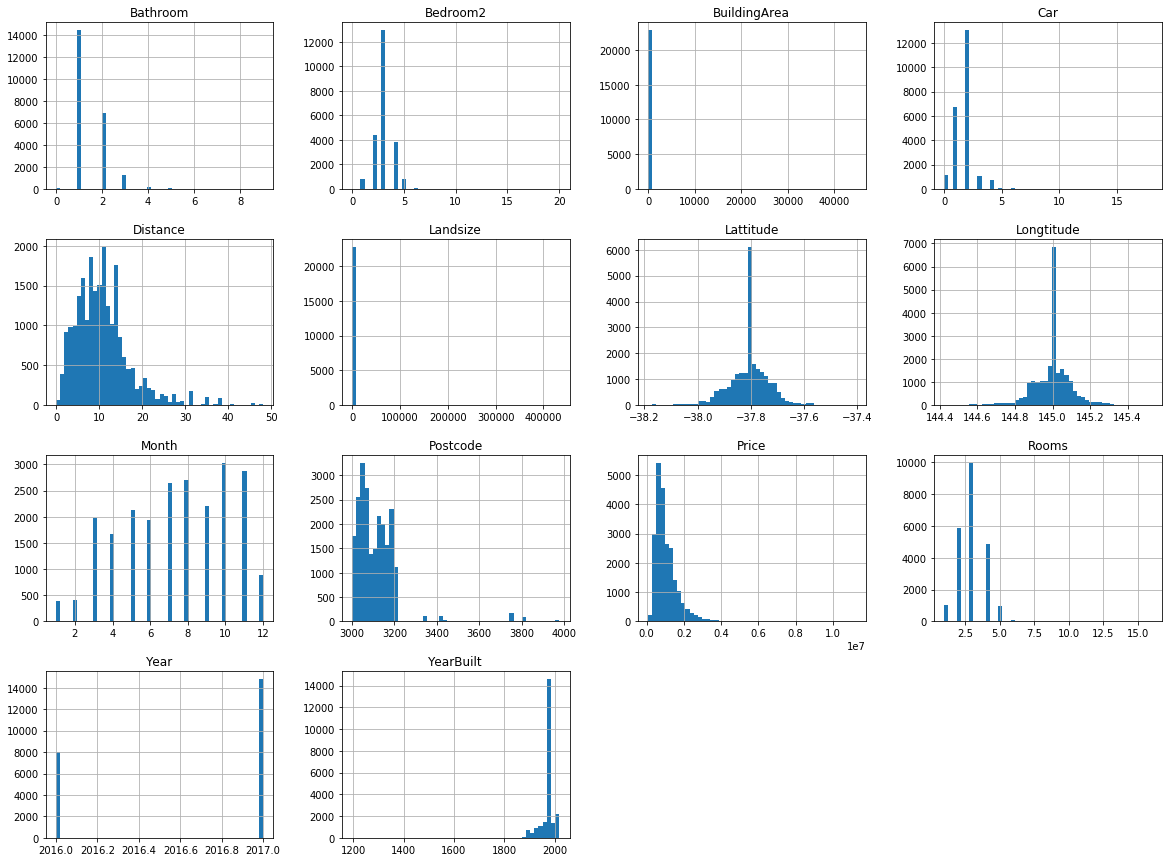

In [13]:
#Plot the relationship between the numeric variables
housing4.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

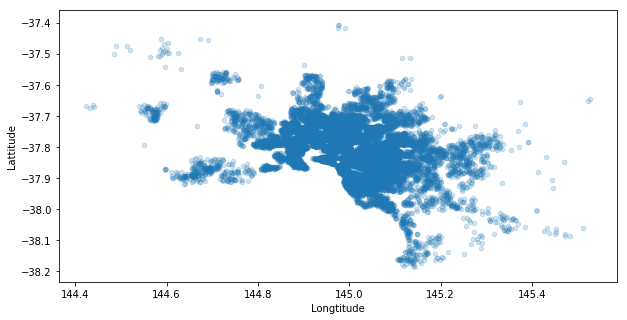

In [14]:
#Plot the longitituda and lattitude to improve the nderstanding of the area
housing4.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.2, figsize=(10,5))

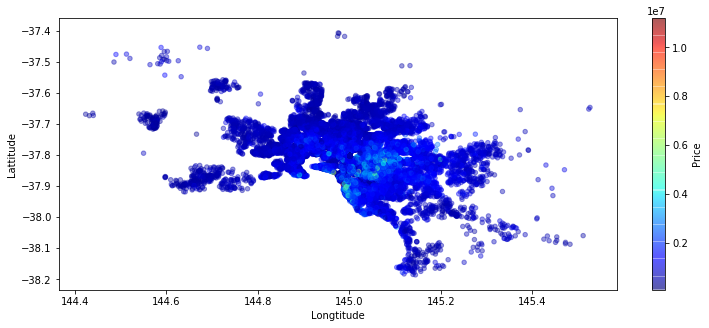

In [15]:
#Plot the prices agasint longtitude and lattitude. Understand the concentration of high prices within regions in Melbourne
housing4.plot(kind="scatter", x="Longtitude", y="Lattitude",
              alpha=0.4, figsize=(12.5,5), c="Price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

In [16]:
#Create new features: One that is the price per built_area and the other one to eliminate the skweness of price
housing4['Price_per_buildingarea'] = housing4['Price']/(housing4['BuildingArea']+1)
housing4['logPrice']  = np.log(housing4['Price'])
housing4['logdistance'] = np.log(housing4['Distance']+1)

In [17]:
#Understand the number of Regions and Suburbs to create a categorical features that classifies 
#the most convenient one according to the price
print('Number of Suburbs:', len(housing4['Suburb'].value_counts()))
print('Number of Regions: ' , len(housing4['Regionname'].value_counts()))

Number of Suburbs: 340
Number of Regions:  8


In [18]:
#Create the clusters of neighbouhoods/suburbs as it will give the adequate level of granularity
#Consider prices and frequency of purchase in each area
freq = housing4.groupby('Suburb').count()['Postcode']
mean = housing4.groupby('Suburb').median()['Price_per_buildingarea']
cluster = pd.concat([freq, mean], axis=1)
cluster['Suburb'] = cluster.index
cluster.columns = ['freq', 'Price_per_buildingarea','Suburb']
cluster.describe()

,freq,Price_per_buildingarea
count,340.000000,340.000000
mean,67.200000,6438.068373
std,83.449389,2215.506212
min,1.000000,2698.493174
25%,11.000000,4809.160305
50%,35.000000,6092.917072
75%,97.000000,7967.596308
max,634.000000,14728.487886


In [19]:
#Divide into 2 clusters: Moderate and Expensive according to price. Create the moderate cluster
cluster1 = cluster[cluster.Price_per_buildingarea <= 6131]
cluster1.index

Index(['Airport West', 'Albanvale', 'Albion', 'Altona Meadows', 'Altona North',
       'Ardeer', 'Attwood', 'Bacchus Marsh', 'Bayswater', 'Bayswater North',
       ...
       'Westmeadows', 'Whittlesea', 'Williams Landing', 'Williamstown North',
       'Wollert', 'Wonga Park', 'Wyndham Vale', 'Yallambie', 'Yarra Glen',
       'croydon'],
      dtype='object', name='Suburb', length=174)

In [20]:
#Create the Expensive cluster
cluster2 = cluster[cluster.Price_per_buildingarea > 6131]
cluster2.index

Index(['Abbotsford', 'Aberfeldie', 'Albert Park', 'Alphington', 'Altona',
       'Armadale', 'Ascot Vale', 'Ashburton', 'Ashwood', 'Aspendale',
       ...
       'Warrandyte', 'Wattle Glen', 'West Footscray', 'West Melbourne',
       'Wheelers Hill', 'Wildwood', 'Williamstown', 'Windsor', 'Yarraville',
       'viewbank'],
      dtype='object', name='Suburb', length=166)

In [21]:
#Add the clusters into the dataset
def get_group(x):
    if x in cluster1.index:
        return 'Moderate'
    else:
        return 'Expensive'
housing4['Neighbourhood'] = housing4.Suburb.apply(get_group)

In [22]:
#Check the features in place after all the data manipulation
housing4.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,CouncilArea,Lattitude,Longtitude,Regionname,Month,Year,Price_per_buildingarea,logPrice,logdistance,Neighbourhood
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067,...,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,3,2016,11297.709924,14.207553,1.252763,Expensive
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067,...,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4,2016,12937.500000,13.849912,1.252763,Expensive
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067,...,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4,2017,9701.986755,14.197366,1.252763,Expensive
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-04-03,2.5,3067,...,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4,2017,6488.549618,13.652992,1.252763,Expensive
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067,...,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4,2016,11188.811189,14.285514,1.252763,Expensive


In [23]:
#Check the values for the new features
housing4.Neighbourhood.unique()

array(['Expensive', 'Moderate'], dtype=object)

In [24]:
#Change the values of the new categorical feature to numerical values
dict ={'Expensive': 0, 'Moderate': 1}
housing4['Neighbourhood'] = housing4['Neighbourhood'].map(dict)

In [25]:
#Check the relationship between logprice and the rest of the features
corr_matrix = housing4.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                     1.000000
logPrice                  0.923464
Rooms                     0.474641
Bedroom2                  0.397255
Bathroom                  0.394819
Car                       0.181345
Longtitude                0.173969
Price_per_buildingarea    0.090104
BuildingArea              0.067707
Postcode                  0.063974
Landsize                  0.028945
Month                     0.010693
Year                     -0.007597
logdistance              -0.161556
Lattitude                -0.186286
Distance                 -0.193722
YearBuilt                -0.228181
Neighbourhood            -0.373004
Name: Price, dtype: float64

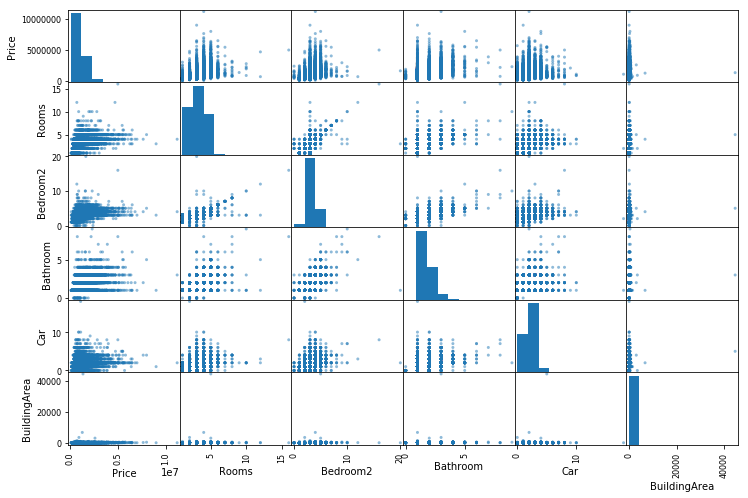

In [26]:
#Plot the relationship between all the numercial features
from pandas.plotting import scatter_matrix

attributes = ["Price", "Rooms", "Bedroom2", "Bathroom",'Car','BuildingArea']
scatter_matrix(housing4[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

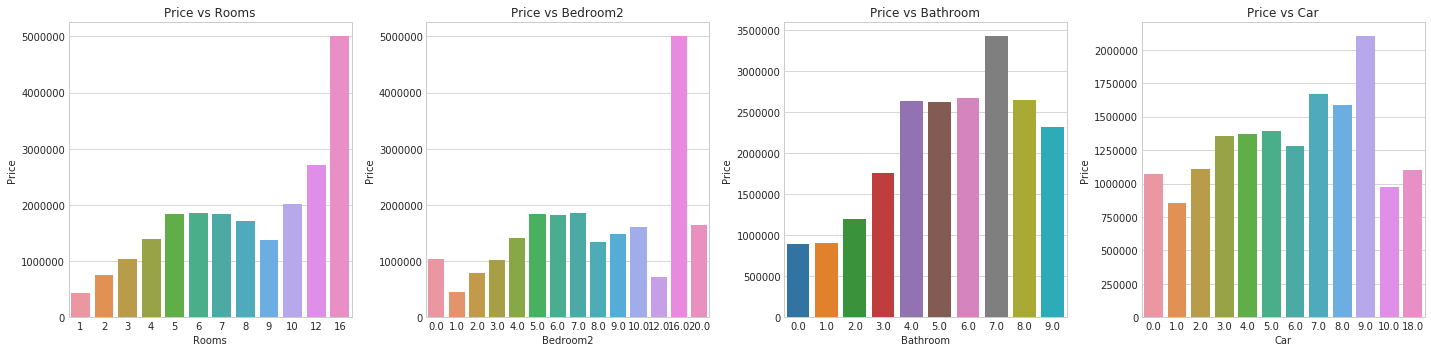

In [27]:
#Visualize the relationship between log Price and the most correlated variables.

plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")

plt.subplot(1, 4, 1)
ax = sns.barplot(x="Rooms", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Rooms')

plt.subplot(1, 4, 2)
ax = sns.barplot(x="Bedroom2", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Bedroom2')

plt.subplot(1, 4, 3)
ax = sns.barplot(x="Bathroom", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Bathroom')

plt.subplot(1, 4, 4)
ax = sns.barplot(x="Car", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Car')

plt.tight_layout()
plt.show()

In [28]:
#Check all the columns in the manipulated dataframe
housing4.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Month', 'Year', 'Price_per_buildingarea',
       'logPrice', 'logdistance', 'Neighbourhood'],
      dtype='object')

In [29]:
#Create a new dataframe that incorporates the new variable Neghibourhood and eliminates the data that is not useful
housing5 = housing4.drop(['Suburb', 'Address', 'Method', 'SellerG', 'Date',
                          'Postcode', 'CouncilArea', 
                                   'Lattitude','Longtitude','Month','Year',#'Regionname'
                         ],axis=1)
housing5.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price_per_buildingarea,logPrice,logdistance,Neighbourhood
count,22848.000000,2.284800e+04,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,2.284800e+04,22848.000000,22848.000000,22848.000000
mean,2.974746,1.056569e+06,10.919984,2.993873,1.441921,1.748906,552.292236,139.666069,1968.259848,1.111200e+04,13.727045,2.336391,0.302083
std,0.962337,6.466361e+05,6.491869,0.855906,0.660357,0.870895,3305.884529,303.657511,25.020923,6.463841e+04,0.521485,0.549662,0.459171
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,3.043849e+01,11.350407,0.000000,0.000000
25%,2.000000,6.370000e+05,6.400000,3.000000,1.000000,1.000000,312.750000,130.000000,1970.000000,5.051881e+03,13.364525,2.001480,0.000000
50%,3.000000,8.800000e+05,10.200000,3.000000,1.000000,2.000000,478.000000,130.000000,1970.000000,6.882188e+03,13.687677,2.415914,0.000000
75%,4.000000,1.300000e+06,13.800000,3.000000,2.000000,2.000000,588.000000,130.000000,1970.000000,9.557252e+03,14.077875,2.694627,1.000000
max,16.000000,1.120000e+07,48.100000,20.000000,9.000000,18.000000,433014.000000,44515.000000,2018.000000,3.450000e+06,16.231424,3.893859,1.000000


In [30]:
#Check values of the feature Regionname to transform into numercial values
housing5.Regionname.unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Eastern Victoria',
       'Northern Victoria', 'Western Victoria'], dtype=object)

In [31]:
#Transform categorical Feature Regionname into numercial values
dict = {'Northern Metropolitan': 1,
        'Western Metropolitan': 2,
       'Southern Metropolitan': 3,
        'Eastern Metropolitan': 4,   
        'South-Eastern Metropolitan': 5,
        'Eastern Victoria' : 6,
       'Northern Victoria' : 7,
        'Western Victoria': 8}
housing5["Regionname"] = housing5["Regionname"].map(dict)

In [32]:
#Build a new feature house Age based on the YearBuilt
housing5 = housing5[housing5.YearBuilt >1970].reset_index(drop=True)
housing5['Age'] = np.log(1+(2018 - housing5['YearBuilt']))
#Drop YearBuilt
housing5.drop('YearBuilt', inplace=True, axis=1)

In [33]:
housing.Type.unique()

array(['h', 'u', 't'], dtype=object)

In [34]:
#Change into numerical the categorical feature Type
dict = {'h': 1, 'u': 2, 't': 3}
housing5['Type']= housing5['Type'].map(dict)

In [35]:
#Eliminate outliers

housing5 = housing5[housing5.Rooms < 16].reset_index(drop=True)

#Describe the dataset
housing5.describe()

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Regionname,Price_per_buildingarea,logPrice,logdistance,Neighbourhood,Age
count,4675.000000,4675.000000,4.675000e+03,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4.675000e+03,4675.000000,4675.000000,4675.000000,4675.000000
mean,3.057326,1.619465,9.360095e+05,12.386118,3.046417,1.800642,1.737326,536.777540,153.389797,2.503743,1.270783e+04,13.607505,2.429676,0.403636,2.801706
std,1.002205,0.772886,6.019829e+05,7.540442,1.002450,0.710608,0.853325,1358.338878,81.262103,1.400126,9.104428e+04,0.502764,0.603011,0.490679,0.733705
min,1.000000,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.208556e+02,11.350407,0.000000,0.000000,0.000000
25%,2.000000,1.000000,5.750000e+05,7.000000,2.000000,1.000000,1.000000,178.000000,108.500000,1.000000,4.397537e+03,13.262125,2.079442,0.000000,2.197225
50%,3.000000,1.000000,7.520000e+05,11.200000,3.000000,2.000000,2.000000,472.000000,130.000000,2.000000,5.898438e+03,13.530492,2.501436,0.000000,2.944439
75%,4.000000,2.000000,1.100000e+06,15.500000,4.000000,2.000000,2.000000,586.000000,182.000000,3.000000,7.671282e+03,13.910821,2.803360,1.000000,3.433987
max,10.000000,3.000000,6.250000e+06,48.100000,10.000000,9.000000,10.000000,40469.000000,934.000000,8.000000,3.450000e+06,15.648092,3.893859,1.000000,3.871201


In [36]:
housing5.columns

Index(['Rooms', 'Type', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'Regionname', 'Price_per_buildingarea',
       'logPrice', 'logdistance', 'Neighbourhood', 'Age'],
      dtype='object')

In [37]:
#Pre-process the data

names = housing5.columns
X = pd.DataFrame(preprocessing.scale(housing5), columns = names)

In [38]:
#Create the predicted and predictors for the model
X1 = X.drop(['logPrice','Price'],axis=1)
Y = X['logPrice']

In [39]:
# Build up the correlation mtrix
Z = X1
correlation_matrix = Z.corr()

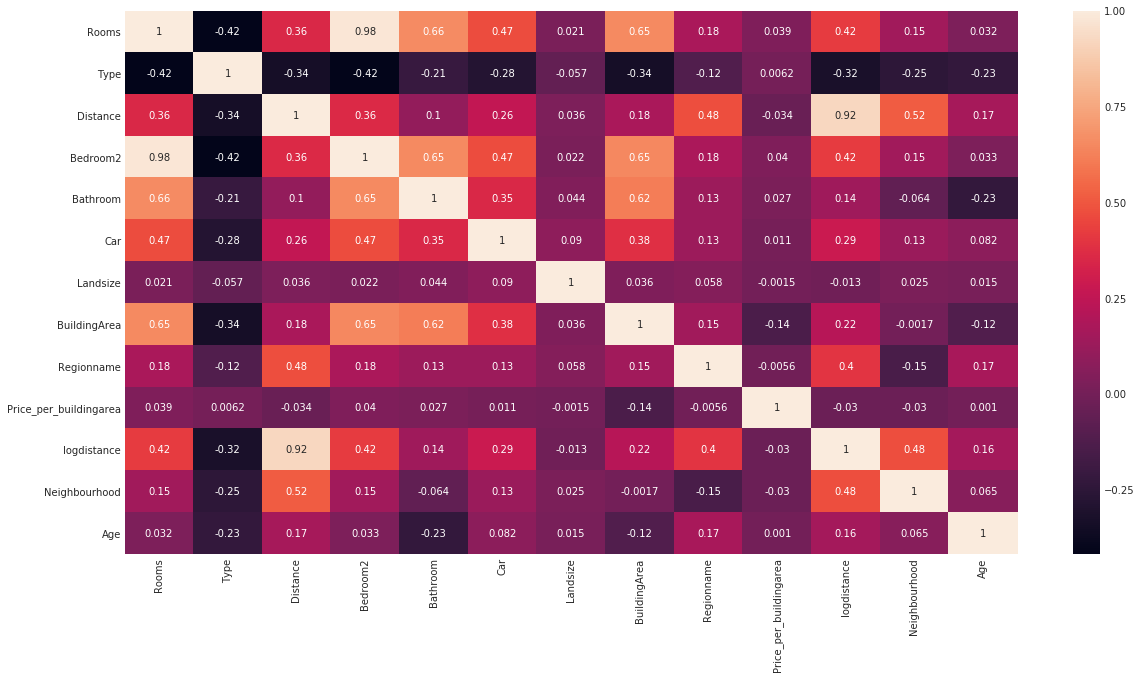

In [40]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(correlation_matrix, annot=True)
plt.show()

***PCA Analysis***

In [41]:
#Eigenvectores & Eigenvalues

eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

sklearn_pca = PCA(n_components=len(Z.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  5.03667060e-01   2.21023077e-01   7.22717581e-02   6.12074205e-02
   5.61101205e-02   4.08566616e-02   2.31595741e-02   1.04458938e-02
   6.28020187e-03   4.74686955e-03   2.08146014e-04   2.32173728e-05
   3.59799168e-33]


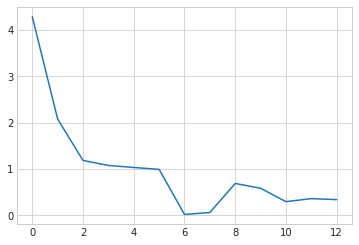

In [42]:
#From the Scree plot.

plt.plot(eig_vals)
plt.show()

In [43]:
#PCA Analysis

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X1)

# Create a PCA object
pca = decomposition.PCA(n_components=6)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features

XPCA = pd.DataFrame(X_std_pca)
XPCA.head()

,0,1,2,3,4,5
0,-1.181245,2.068699,-0.932141,0.541832,-0.115369,-0.344685
1,-0.906643,2.173717,-0.439735,1.022163,-0.482466,-0.747562
2,-2.870435,1.574725,-0.391456,-0.034544,0.034132,-0.230078
3,-2.953217,0.316292,-0.046936,1.658553,-0.533100,-1.221459
4,-1.897297,2.362322,-0.384511,-0.278161,0.251548,-0.013281


***Recursive Feature Elimination & PCA***

In [44]:
# create the RFE model and select features

lr = LinearRegression()
nfeatures = 4
rfe = RFE(lr,nfeatures)
fit = rfe.fit(X1,Y)

# summarize the selection of the features

result_RFE = pd.DataFrame(list(zip(X1.head(0), rfe.ranking_, rfe.support_)),columns=['Features','Ranking','Support'] )
result_RFE.sort_values('Ranking')

,Features,Ranking,Support
0,Rooms,1,True
2,Distance,1,True
7,BuildingArea,1,True
11,Neighbourhood,1,True
4,Bathroom,2,False
8,Regionname,3,False
5,Car,4,False
9,Price_per_buildingarea,5,False
1,Type,6,False
12,Age,7,False


***Feature Importance with Random Forest***

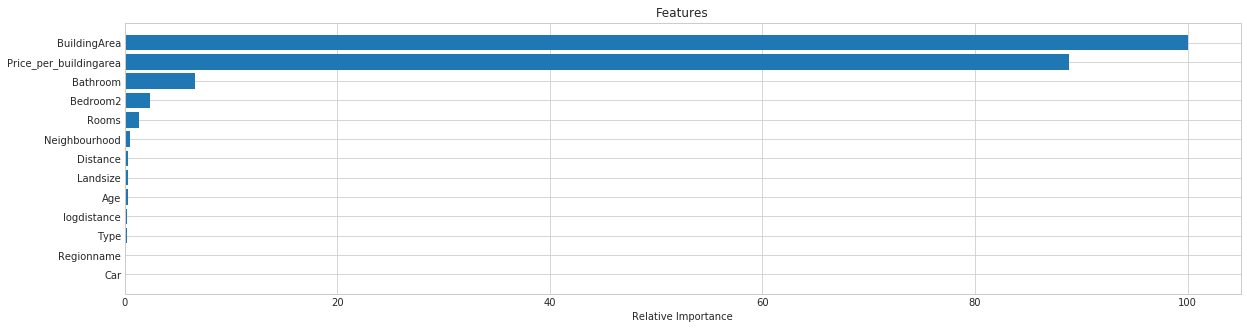

In [45]:
#Calculate Feature Importance using Random Forest

rf = RandomForestRegressor()
rf.fit(X1, Y)

#Define feature importance
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20, 5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Features')
plt.show()

In [46]:
#Feature Selection. Scores for the most relevant features (should we start with the one that has more explanatory power)
from sklearn.feature_selection import SelectKBest

# feature extraction
test = SelectKBest()
fit = test.fit(X1, Y)

#Identify features with highest score from a predictive perspective (for all programs)
names2 = X1.columns
Bestfeatures = pd.DataFrame(fit.scores_, index = names2)
Bestfeatures.columns = ['Best Features']
Bestfeatures.sort_values(by=['Best Features'], ascending=False)

,Best Features
Price_per_buildingarea,7.303251
BuildingArea,3.733349
Bathroom,3.521498
Rooms,2.637593
Bedroom2,2.556699
Neighbourhood,1.911491
Car,1.531757
Regionname,1.352306
Age,1.163272
Distance,1.128241


In [47]:
#Build new set of features

#Initial features
names = ['Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'Regionname', 'Price_per_buildingarea',
       'Neighbourhood', 'Age']

X0 = X1[names]

#Recursive Feature Elimination

namesRFE = ['Rooms','Bathroom','Car', 'Type', 'Distance', 'Regionname', 'Neighbourhood','Age']

XRFE = X1[namesRFE]

#Best Select Features
namesBS = ['Rooms', 'Bathroom', 'Price_per_buildingarea', 'Neighbourhood']

XBS = X1[namesBS]

#Feature Importance (Random Forest)
namesFIRF = ['Rooms', 'Type', 'BuildingArea', 'Price_per_buildingarea', 'Neighbourhood']

XFIRF = X1[namesFIRF]

***Feature Selection using Lasso***

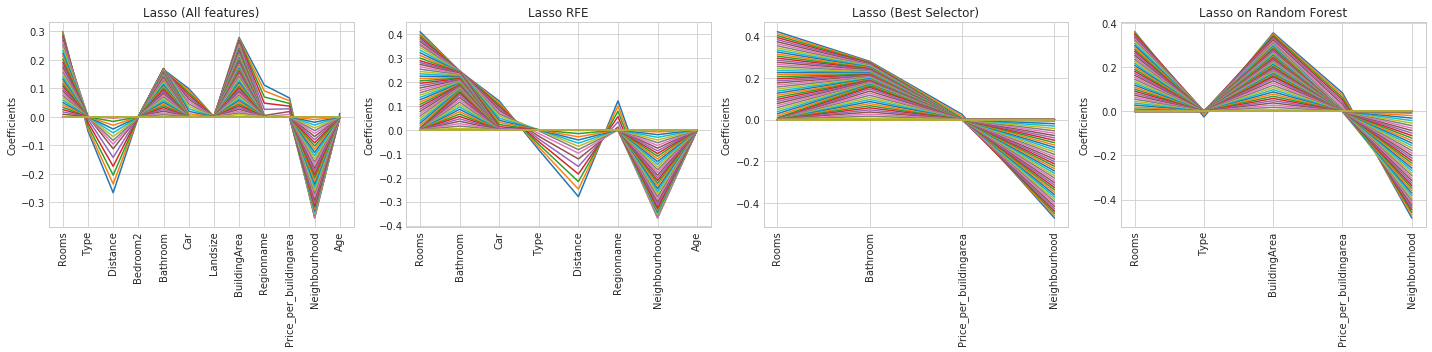

In [48]:
#Feature Selection using Lasso

plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")

plt.subplot(1, 4, 1)
for lambd in [x * 0.01 for x in range(1, 100)]:
    lasso = Lasso(alpha=lambd)
    lasso_coef = lasso.fit(X0, Y).coef_
    plt.xticks(range(len(names)), names, rotation=90)
    plt.ylabel('Coefficients')
    plt.plot(range(len(names)), lasso_coef)
    plt.title('Lasso (All features)')

plt.subplot(1, 4, 2)
for lambd in [x * 0.01 for x in range(1, 100)]:
    lasso = Lasso(alpha=lambd)
    lasso_coef = lasso.fit(XRFE, Y).coef_
    plt.xticks(range(len(namesRFE)), namesRFE, rotation=90)
    plt.ylabel('Coefficients')
    plt.plot(range(len(namesRFE)), lasso_coef)
    plt.title('Lasso RFE')

plt.subplot(1, 4, 3)    
for lambd in [x * 0.01 for x in range(1, 100)]:
    lasso = Lasso(alpha=lambd)
    lasso_coef = lasso.fit(XBS, Y).coef_
    plt.xticks(range(len(namesBS)), namesBS, rotation=90)
    plt.ylabel('Coefficients')
    plt.plot(range(len(namesBS)), lasso_coef)
    plt.title('Lasso (Best Selector)')
    
plt.subplot(1, 4, 4)
for lambd in [x * 0.01 for x in range(1, 100)]:
    lasso = Lasso(alpha=lambd)
    lasso_coef = lasso.fit(XFIRF, Y).coef_
    plt.xticks(range(len(namesFIRF)), namesFIRF, rotation=90)
    plt.ylabel('Coefficients')
    plt.plot(range(len(namesFIRF)), lasso_coef)
    plt.title('Lasso on Random Forest')
    
plt.tight_layout()
plt.show()

In [49]:
#New set of features based on results obtained in with Lasso, Random Forest and RFE

Xl = X1[['Rooms', 'BuildingArea', 'Regionname','Distance', 'Neighbourhood']]

In [50]:
#Split the data into training and testing datasets. Split: 70/30; train/test

X_train, X_test, y_train, y_test = train_test_split(Xl,Y, test_size=0.3, random_state=0)

#Initiating the cross validation generator, N splits = 5
kf = KFold(5)

***Linear Regression***

In [51]:
#Fit the Linear Regression model with the PCA features
lr = LinearRegression()

lr.fit(X_train, y_train)

print(lr.coef_)

[ 0.44796147  0.35515817  0.13961603 -0.2853248  -0.33904296]


In [52]:
#Predict the value of y
y_pred = lr.predict(X_test)

#Mean squared error of the regressor
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)

#Accuracy of the regressor
accln = cross_val_score(lr, X_test, y_test, cv=kf).mean()
acclnpca = cross_val_score(lr, XPCA, Y, cv=kf).mean()

print('RMSE: %.4f' % lin_rmse)
print('Linear Regression Accuracy: %.4f' % accln)
print('Linear Regression Accuracy PCA: %.4f' % acclnpca)

RMSE: 0.5799
Linear Regression Accuracy: 0.6702
Linear Regression Accuracy PCA: 0.6774


***Ridge Regression***

In [53]:
# Testing the Ridge Regression.

ridgeregr = Ridge()

k1 = np.arange(50)+1

parameters = {'alpha': k1}

#Fit parameters

ridgeregr1 = GridSearchCV(ridgeregr, param_grid=parameters, cv=kf)


#Fit the tunned classifier in the traiing space
ridgeregr1.fit(X_train, y_train)

#Print the best parameters
print(ridgeregr1.best_params_)

{'alpha': 12}


In [54]:
# Fit the model.
ridgeregr1.fit(X_test, y_test)

#Predict the value of y
y_pred = ridgeregr1.predict(X_test)

#Mean squared error of the regressor
rid_mse = mean_squared_error(y_pred, y_test)
rid_rmse = np.sqrt(rid_mse)

#Accuracy of the regressor
accridg = cross_val_score(ridgeregr1, X_test, y_test, cv=kf).mean()
accridgpca = cross_val_score(ridgeregr1, XPCA, Y, cv=kf).mean()

print('RMSE: %.4f' % rid_rmse)
print('Ridge Regression Accuracy: %.4f' % accridg)
print('Ridge Regression Accuracy PCA: %.4f' % accridgpca)

RMSE: 0.5748
Ridge Regression Accuracy: 0.6699
Ridge Regression Accuracy PCA: 0.6774


***Random Forest***

In [55]:
#Initialize and fit the model

abc = RandomForestRegressor(n_jobs=-1)

#Create range of values to fit parameters

k2 = ['mse','mae']
k4 = ['auto','log2']
k3 = [150, 200,250, 300]

parameters = { 'criterion': k2,
              'n_estimators': k3,
             'max_features': k4
}

#Fit parameters

clf = GridSearchCV(abc, param_grid=parameters, cv=kf)

clf.fit(X_train,y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", clf.best_params_)

Best Hyper Parameters: {'criterion': 'mae', 'max_features': 'log2', 'n_estimators': 150}


In [56]:
#Predict the value of y
y_pred = clf.predict(X_test)

#Mean squared error of the regressor
rf_mse = mean_squared_error(y_pred, y_test)
rf_rmse = np.sqrt(rf_mse)

#Accuracy of the regressor
accrf = cross_val_score(clf, X_test, y_test, cv=kf).mean()
accrfpca = cross_val_score(clf, XPCA, Y, cv=kf).mean()


print('RMSE: %.4f' % rf_rmse)
print('Random Forest Accuracy:  %.4f' % accrf)
print('Random Forest Accuracy PCA:  %.4f' % accrfpca)

RMSE: 0.4282
Random Forest Accuracy:  0.8021
Random Forest Accuracy PCA:  0.7876


***Decision Tree & Ada Boost Regressor***

In [57]:
#Initialize and fit the model

rf = DecisionTreeRegressor()
rfA = AdaBoostRegressor()

#Create range of values to fit parameters

k1  =['best']
k2 = ['mse','friedman_mse']
k3 = [100, 150, 200]
k4 = ['auto','sqrt']

parameters = {'criterion': k2,
              'splitter': k1,
             'max_features': k4
             }
parameters2 = {'n_estimators':k3}

#Fit parameters

rf1 = GridSearchCV(rf, param_grid=parameters, cv=kf)
rf2 = GridSearchCV(rfA, param_grid=parameters2, cv=kf)


rf1.fit(X_train,y_train)
rf2.fit(X_train,y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", rf1.best_params_)
print("Best Hyper Parameters:", rf2.best_params_)

Best Hyper Parameters: {'criterion': 'mse', 'max_features': 'sqrt', 'splitter': 'best'}
Best Hyper Parameters: {'n_estimators': 150}


In [58]:
#Predict the value of y
y_pred = rf1.predict(X_test)
y_pred2 = rf2.predict(X_test)

#Mean squared error of the regressor
dt_mse = mean_squared_error(y_pred, y_test)
dt_rmse = np.sqrt(dt_mse)
ada_mse2 = mean_squared_error(y_pred2, y_test)
ada_rmse2 = np.sqrt(ada_mse2)

#Accuracy of the regressor
accdt = cross_val_score(rf1, X_test, y_test, cv=kf).mean()
accada = cross_val_score(rf2, X_test, y_test, cv=kf).mean()

#Accuracy of the regressor
accdtpca = cross_val_score(rf1, XPCA, Y, cv=kf).mean()
accadapca = cross_val_score(rf2, XPCA, Y, cv=kf).mean()

print('RMSE: %.4f' % dt_rmse)
print('RMSE: %.4f' % ada_rmse2)

print('Decision Tree Accuracy:  %.4f' % accdt)
print('Decision Tree Accuracy PCA:  %.4f' % accdtpca)
print('Ada Boost Accuracy:  %.4f' % accada)
print('Ada Boost Accuracy PCA:  %.4f' % accadapca)

RMSE: 0.5711
RMSE: 0.5165
Decision Tree Accuracy:  0.6456
Decision Tree Accuracy PCA:  0.5822
Ada Boost Accuracy:  0.7215
Ada Boost Accuracy PCA:  0.6950


***Gradient Boosting***

In [59]:
# Train model
GBR = GradientBoostingRegressor()

k2 = ['ls','huber']
k4 = [200,300, 350]

parameters = { 'loss': k2,
             'n_estimators': k4}

#Fit parameters

GBR1 = GridSearchCV(GBR, param_grid=parameters, cv=kf)

GBR1.fit(X_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", GBR1.best_params_)

Best Hyper Parameters: {'loss': 'huber', 'n_estimators': 350}


In [60]:
#Predict the value of y
y_pred = GBR1.predict(X_test)

#Mean squared error of the regressor
gb_mse = mean_squared_error(y_pred, y_test)
gb_rmse = np.sqrt(gb_mse)

#Accuracy of the regressor
accgd = cross_val_score(GBR1, X_test, y_test, cv=kf).mean()
accgdpca = cross_val_score(GBR1, XPCA, Y, cv=kf).mean()

print('RMSE: %.4f' % gb_rmse)
print('Gradient Boosting Regressor Accuracy: %.4f' % accgd)
print('Gradient Boosting Regressor Accuracy PCA: %.4f' % accgdpca)

RMSE: 0.4206
Gradient Boosting Regressor Accuracy: 0.7972
Gradient Boosting Regressor Accuracy PCA: 0.7739


***KNN Regressor***

In [61]:
#Initialize and fit the model

KNR = KNeighborsRegressor(n_jobs=-1)

#Create range of values to fit parameters

#Create range of values to fit parameters

k1 = [17,19,21,23,25]
k3 = ['distance']

parameters = {'n_neighbors': k1, 'weights':k3}

#Fit parameters

KNR1 = GridSearchCV(KNR, param_grid=parameters, cv=kf)

KNR1.fit(X_train,y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", KNR1.best_params_)

Best Hyper Parameters: {'n_neighbors': 19, 'weights': 'distance'}


In [62]:
#Predict the value of y
y_pred = KNR1.predict(X_test)

#Mean squred error of the regressor
KNR_mse = mean_squared_error(y_pred, y_test)
KNR_rmse = np.sqrt(KNR_mse)

#Accuracy of the regressor
accKNR1 = cross_val_score(KNR1, X_test, y_test, cv=kf).mean()
accKNR1pca = cross_val_score(KNR1, XPCA, Y, cv=kf).mean()


print('RMSE: %.4f' % KNR_rmse)
print('KN Regressor Accuracy: %.4f' % accKNR1)
print('KN Regressor Accuracy PCA: %.4f' % accKNR1pca)

RMSE: 0.4647
KN Regressor Accuracy: 0.7738
KN Regressor Accuracy PCA: 0.7708


***SVR***

In [63]:
#Initialize and fit the model

SVR0 = SVR()

#Create range of values to fit parameters


k1 = [1, 10, 100,]
k3 = ['linear', 'poly', 'rbf', 'sigmoid']

parameters = {'C': k1,
          'kernel':k3}

#Fit parameters

SVR1 = GridSearchCV(SVR0, param_grid=parameters, cv=kf)

SVR1.fit(X_train,y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", SVR1.best_params_)

Best Hyper Parameters: {'C': 10, 'kernel': 'rbf'}


In [64]:
#Predict the value of y
y_pred = SVR1.predict(X_test)

#Mean squared error of the regressor
svr_mse = mean_squared_error(y_pred, y_test)
svr_rmse = np.sqrt(svr_mse)

#Accuracy of the regressor
accsvr1 = cross_val_score(SVR1, X_test, y_test, cv=kf).mean()
accsvr1pca = cross_val_score(SVR1, XPCA, Y, cv=kf).mean()

print('RMSE: %.4f' % svr_rmse)
print('SVR Accuracy: %.4f' % accsvr1)
print('SVR Accuracy: %.4f' % accsvr1pca)

RMSE: 0.4372
SVR Accuracy: 0.7805
SVR Accuracy: 0.7788


The dataset contained the Melbourne real estate market prices for form 2016 until September 2017. To clean the dataset, first the data was analyzed and only the data for one complete year was taken (sept 2016 - sept 2017). Additionally, the data points that didn´t contain prices were eliminated and the rest of the missing data points were replaced by the median of the column. The price presented a skewed to the left distribution and to smoothen it into a normal distribution, the logarithm of the price was used as an output variable

The relationship between the variables was analyzed being Rooms, bedroom2 and bathroom the ones that showed a higher correlation with the price. From a "Rooms" variable perspective, there were outliers that were reducing the accuracy of the models, hence, all data points with more than 10 rooms were eliminated increasing the accuracy of all the models by approx. 5% (except KNN and random forest).
Feature selection was done with RFE, Feature importance and Lasso regression. The difference between them was significant, being the final set of features that is giving better accuracy the one obtained through feature importance using random fores.:
Linear regression, randomforest, Decisiontreeregression, KNN and gradient boosting models were set on the training set and the hyperparameters were tuned. The model were passed through the test set.